In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

In [2]:
# some parameters 
BATCH_SIZE = 1024
learning_rate = 0.01
epochs = 100

In [3]:
# turn on cuda
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda', 0)
    
print(type(device), device)

<class 'torch.device'> cuda:0


In [4]:
data = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv').values.reshape(-1, 1, 28, 28)

from sklearn.model_selection import train_test_split

X = data.drop('label', axis=1).values.reshape(-1, 1, 28, 28)
Y = data['label'].values


X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.25, random_state=42)

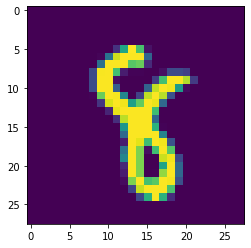

In [5]:
plt.imshow(X_train[1, 0])
plt.show()

In [6]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [7]:
from torch.nn import Module, Conv2d, Linear, MaxPool2d, ReLU, LogSoftmax, Dropout
from torch import flatten

class LeNet(Module):
  def __init__(self, num_channels, classes):
    super(LeNet, self).__init__()
    self.model = torch.nn.Sequential(
                  Conv2d(in_channels=num_channels, out_channels=20,
			  kernel_size=(5, 5)),
                  ReLU(),
                  MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
                  Conv2d(in_channels=20, out_channels=50,
			kernel_size=(5, 5)),
                  ReLU(),
                  MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),
                  Flatten(),
                  Dropout(0.3),
                  Linear(in_features=800, out_features=500),
                  ReLU(),
                  Dropout(0.3),
                  Linear(in_features=500, out_features=classes),
                  LogSoftmax(dim=1)
    )
  def forward(self, x):
	  return self.model(x)

In [8]:
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32).to(device)
        self.y = torch.tensor(y,dtype=torch.long).to(device)
        self.length = self.x.shape[0]
 
    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
    def __len__(self):
        return self.length

trainset = dataset(X_train, Y_train)

trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=False)

In [9]:
# Model , Optimizer, Loss
model = LeNet(num_channels=1, classes=10)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate)
loss_fn = torch.nn.NLLLoss()

In [10]:
from tqdm import tqdm
from sklearn.metrics import balanced_accuracy_score
losses = []
accur = []
for i in tqdm(range(epochs)):
    for j, (x_train, y_train) in enumerate(trainloader):
    #calculate output
        output = model(x_train)
    #calculate loss
        loss = loss_fn(output,y_train)
    #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if i%25 == 0:
        model.eval()
        with torch.no_grad():
            predicted = model(torch.tensor(X_val,dtype=torch.float32).to(device))
            predicted = predicted.detach().argmax(dim=1).cpu().numpy()
            acc = (predicted == Y_val).mean()
            losses.append(loss)
            accur.append(acc)
            print("\n epoch {}\tloss : {}\t accuracy: {}".format(i,loss,acc))

  1%|          | 1/100 [00:02<04:21,  2.64s/it]


 epoch 0	loss : 2.266256093978882	 accuracy: 0.21876190476190477


 26%|██▌       | 26/100 [00:18<00:37,  1.98it/s]


 epoch 25	loss : 0.030045202001929283	 accuracy: 0.9767619047619047


 51%|█████     | 51/100 [00:27<00:18,  2.59it/s]


 epoch 50	loss : 0.008696168661117554	 accuracy: 0.9824761904761905


 76%|███████▌  | 76/100 [00:36<00:09,  2.53it/s]


 epoch 75	loss : 0.0038260475266724825	 accuracy: 0.9828571428571429


100%|██████████| 100/100 [00:44<00:00,  2.25it/s]


[0]


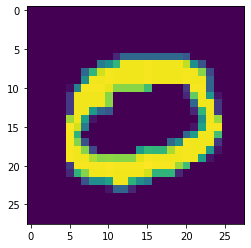

In [11]:
predict = model(torch.tensor(X_test[1:2], dtype=torch.float32).to(device))
plt.imshow(X_test[1, 0])
plt.plot()
print(predict.detach().argmax(dim=1).cpu().numpy())

In [24]:
# predict test
prediction = model(torch.tensor(X_test, dtype=torch.float32).to(device)).detach().argmax(dim=1).cpu().numpy()

prediction=pd.DataFrame(prediction, range(1, 1 + len(prediction)), ['Label'])
prediction['Label'] = prediction['Label'].astype('str')
prediction.to_csv('results.csv', index_label='ImageId')

In [12]:
# save model
torch.save(model.state_dict(), 'trained_model.torch')